In [104]:
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd
import matplotlib.pyplot as plt
from dir import *
from VAE_model import *
from VAE_model_single import *
from VAE_MoG_model import *
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')

# 1) Data exploration 

## 1.1) Overall exporation 

In [100]:
data = pd.read_csv(PANGENOME_MATRIX_CSV, index_col=[0], header=[0])

In [106]:
phylogroup_data = pd.read_csv('accessionID_phylogroup2.csv', index_col=[0], header=[0])

In [108]:
phylogroup_data

,Phylogroup
AccessionID,
GCF_000005845,A
GCF_000007445,B2
GCF_000008865,E
GCF_000009565,A
GCF_000010245,A
...,...
GCF_904866495,D
GCF_905071835,F
GCF_905071865,A


In [3]:
data

,GCF_009363035,GCF_016889545,GCF_008065455,GCF_015135355,GCF_000026545,GCF_002012065,GCF_009650175,GCF_016903815,GCF_005221505,GCF_001559655,...,GCF_010365525,GCF_009832985,GCF_013374295,GCF_014168955,GCF_011769865,GCF_000725305,GCF_008124285,GCF_017165375,GCF_001663075,GCF_000022665
GF_ID,,,,,,,,,,,,,,,,,,,,,
GF_1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GF_31460,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GF_31461,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GF_31462,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [4]:
data.dtypes

GCF_009363035    int64
GCF_016889545    int64
GCF_008065455    int64
GCF_015135355    int64
GCF_000026545    int64
                 ...  
GCF_000725305    int64
GCF_008124285    int64
GCF_017165375    int64
GCF_001663075    int64
GCF_000022665    int64
Length: 1324, dtype: object

In [5]:
data.transpose()

GF_ID,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31455,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_001663075,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [6]:
data.transpose()[data.transpose()[data.transpose().columns].eq(0).all(1)]

GF_ID,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31455,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465


In [7]:
data.columns

Index(['GCF_009363035', 'GCF_016889545', 'GCF_008065455', 'GCF_015135355',
       'GCF_000026545', 'GCF_002012065', 'GCF_009650175', 'GCF_016903815',
       'GCF_005221505', 'GCF_001559655',
       ...
       'GCF_010365525', 'GCF_009832985', 'GCF_013374295', 'GCF_014168955',
       'GCF_011769865', 'GCF_000725305', 'GCF_008124285', 'GCF_017165375',
       'GCF_001663075', 'GCF_000022665'],
      dtype='object', length=1324)

In [8]:
percent_GF_present = data.astype(bool).sum(axis=0) / len(data.index) * 100

In [9]:
percent_GF_present

GCF_009363035    16.990559
GCF_016889545    16.372935
GCF_008065455    16.585366
GCF_015135355    16.443745
GCF_000026545    17.053501
                   ...    
GCF_000725305    15.609756
GCF_008124285    15.778914
GCF_017165375    17.816680
GCF_001663075    15.243902
GCF_000022665    15.062943
Length: 1324, dtype: float64

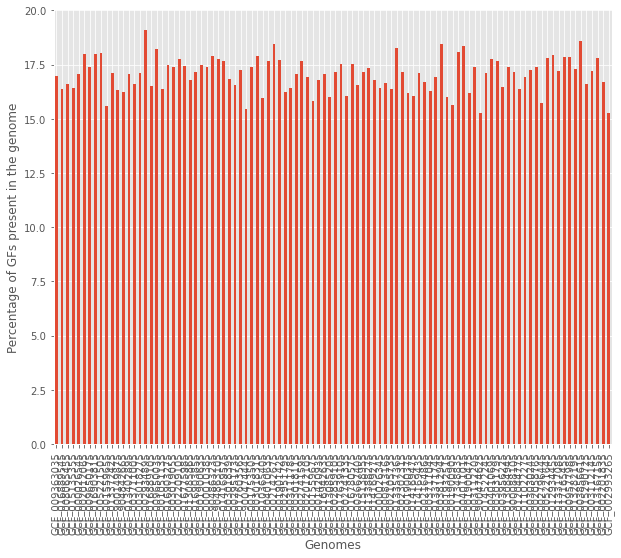

In [10]:
plt.figure(figsize=(10, 8))
percent_GF_present.iloc[:100].plot(kind='bar')
plt.xlabel('Genomes')
plt.ylabel('Percentage of GFs present in the genome')
plt.show()

In [11]:
frequency1 = data.sum(axis=1)

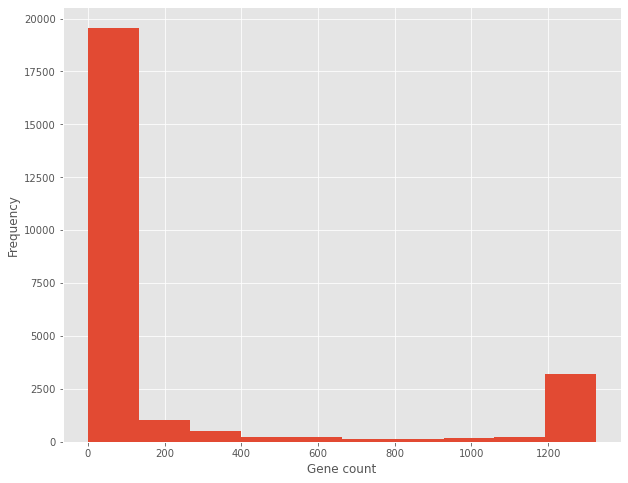

In [12]:
plt.figure(figsize=(10,8))
plt.hist(frequency1)
plt.xlabel('Gene count')
plt.ylabel('Frequency')
plt.show()

In [13]:
frequency2 = data.sum(0)

In [14]:
frequency2

GCF_009363035    4319
GCF_016889545    4162
GCF_008065455    4216
GCF_015135355    4180
GCF_000026545    4335
                 ... 
GCF_000725305    3968
GCF_008124285    4011
GCF_017165375    4529
GCF_001663075    3875
GCF_000022665    3829
Length: 1324, dtype: int64

In [15]:
# plt.figure(figsize=(10,8))
# plt.hist(frequency2, bin=20)
# plt.xlabel('Genome size')
# plt.ylabel('Gene Gamily Frequency')
# plt.show()

In [16]:
threshold_data = []
thresholds = np.linspace(0, 20, num=10)

for i in thresholds:
    row_sums = data.sum(axis=1)
    threshold_data.append(len(data[row_sums >= i]))


In [17]:
threshold_data

[25420, 17020, 14507, 13058, 12127, 11221, 10721, 10330, 10005, 9730]

In [18]:
thresholds

array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
       11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ])

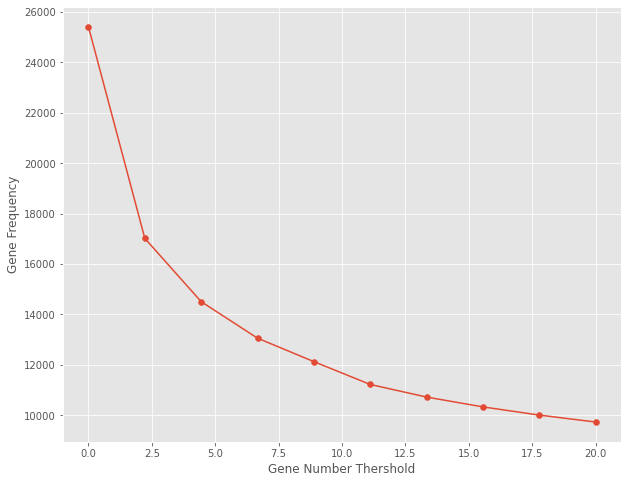

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(thresholds, threshold_data)
plt.plot(thresholds, threshold_data)
plt.xlabel('Gene Number Thershold')
plt.ylabel('Gene Frequency')
plt.show()

In [120]:
data.transpose()

GF_ID,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31455,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_001663075,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


## 1.2) PCA

In [121]:
merged_df = pd.merge(data.transpose(), phylogroup_data, how='inner', left_index=True, right_on='AccessionID')

In [122]:
merged_df

,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465,Phylogroup
AccessionID,,,,,,,,,,,,,,,,,,,,,
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,E


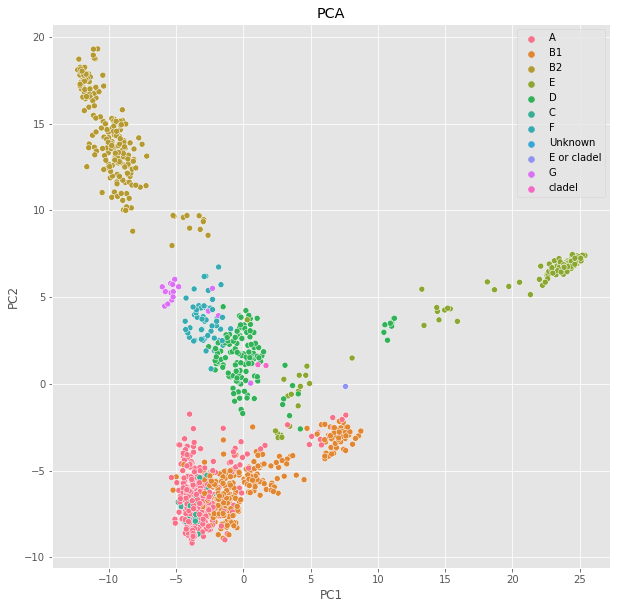

In [125]:
# Apply PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(merged_df.iloc[:, :-1])
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

# Visualize the first two principal components
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = merged_df.Phylogroup.tolist(), data=df_pca)
plt.title('PCA')
plt.show()

In [21]:
df_pca

,PC1,PC2
0,-3.560677,-6.627116
1,-2.650110,-7.136572
2,-0.299936,-6.008099
3,-4.996945,-5.365163
4,-2.953077,9.467883
...,...,...
1319,-4.086980,-7.939809
1320,-2.994488,-7.807338
1321,24.643630,7.241193
1322,-3.746871,-8.790186


In [22]:
from scipy.stats import shapiro

In [23]:
shapiro_test_pc1 = shapiro(df_pca['PC1'])
shapiro_test_pc2 = shapiro(df_pca['PC2'])
print(f"Shapiro-Wilk Test for PC1: {shapiro_test_pc1}")
print(f"Shapiro-Wilk Test for PC2: {shapiro_test_pc2}")

Shapiro-Wilk Test for PC1: ShapiroResult(statistic=0.7767663598060608, pvalue=4.115196002779619e-39)
Shapiro-Wilk Test for PC2: ShapiroResult(statistic=0.8642285466194153, pvalue=2.331999472027804e-32)


# 2) Data preprocessing  

In [24]:
row_sums = data.sum(axis=1)
filtered_data = data[row_sums >= 20]

In [25]:
filtered_data

,GCF_009363035,GCF_016889545,GCF_008065455,GCF_015135355,GCF_000026545,GCF_002012065,GCF_009650175,GCF_016903815,GCF_005221505,GCF_001559655,...,GCF_010365525,GCF_009832985,GCF_013374295,GCF_014168955,GCF_011769865,GCF_000725305,GCF_008124285,GCF_017165375,GCF_001663075,GCF_000022665
GF_ID,,,,,,,,,,,,,,,,,,,,,
GF_1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_14,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_17,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GF_31460,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GF_31461,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GF_31462,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [26]:
data_array_t = np.array(filtered_data.transpose())

In [27]:
data_array_t

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [28]:
data_array_t.shape

(1324, 9730)

In [29]:
data_array_t.shape[1]

9730

In [30]:
# # Normalizing the data with Standard Scaler
# scaler = StandardScaler()
# data_normalized = scaler.fit_transform(data_array_t)

# Convert to PyTorch tensor
data_tensor = torch.tensor(data_array_t, dtype=torch.float32)

# Split into train and test sets
train_data, val_data = train_test_split(data_tensor, test_size=0.2, random_state=12345)

# TensorDataset
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

# DataLoaders for main training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Dataloader for overfitting on one sample (for dubbiging purposes)
input_dim = data_array_t.shape[1]
binary_data = torch.tensor(np.random.randint(0, 2, size=(1, input_dim)), dtype=torch.float32)
single_sample_dataset = TensorDataset(binary_data)
single_sample_loader = DataLoader(single_sample_dataset, batch_size=1, shuffle=True)

# Dataloader fot a small subset for overfitting (again, for debugging)
small_subset_indices = np.random.choice(len(train_dataset), size=256, replace=False)
small_subset = Subset(train_dataset, small_subset_indices)
small_loader = DataLoader(small_subset, batch_size=batch_size, shuffle=True)

In [31]:
len(train_dataset)

1059

In [32]:
len(train_loader)

34

In [33]:
len(train_dataset)

1059

In [34]:
len(val_dataset)

265

In [35]:
train_data

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.]])

In [36]:
TensorDataset(train_data)

In [37]:
TensorDataset(torch.tensor(train_data))

/var/folders/nx/hnfjrvz145n2_hzn95z65pmc0000gn/T/ipykernel_3830/4253064978.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(train_data))


In [38]:
print(data_tensor)

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


# 3) Overfitting on a single sample and small data subset

## 3.1) Overfitting on a single sample

In [39]:
single_sample = torch.randn(1, data_array_t.shape[1])

In [40]:
single_sample.shape[0]

1

In [41]:
# NO GRADIENT CLIPPING AND SCHEDULER 
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0
free_bits = 0.1
n_epochs = 10

model = VAE_single(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Overfitting one sample to see if the model is broken 
model.train()
num_epochs = 1000

# Collecting data for visualisation 
train_loss_vals1 = []
train_loss_vals2 = []
kl_divergences_no_beta = []
kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / n_epochs
    epoch_kl_divergence = 0
    epoch_kl_divergence_beta = 0 
    
    for data in single_sample_loader:
        data = data[0].to(torch.float)
        # print(data)
        
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())
        
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        epoch_kl_divergence += kl_divergence_loss.item()
        epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        loss = reconstruction_loss + kl_divergence_loss
        loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        # Backpropagation
        loss.backward()
        optimizer.step()   

    if epoch % 100 == 0:
        print(f"Epoch {epoch}\nLoss (method1) = {loss.item()}\nLoss (method2) = {loss2.item()}")

    train_loss_vals1.append(loss.item())
    train_loss_vals2.append(loss2.item())

    kl_divergences_no_beta.append(epoch_kl_divergence / len(train_loader.dataset))
    kl_divergences_beta.append(epoch_kl_divergence_beta / len(train_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss.item()}")

Epoch 0
Loss (method1) = 6871.30126953125
Loss (method2) = 6815.84033203125
Epoch 100
Loss (method1) = 19.13418960571289
Loss (method2) = 19.20967674255371
Epoch 200
Loss (method1) = 6.991706371307373
Loss (method2) = 7.069886207580566
Epoch 300
Loss (method1) = 3.2473740577697754
Loss (method2) = 3.360116481781006
Epoch 400
Loss (method1) = 1.7664854526519775
Loss (method2) = 1.8136314153671265
Epoch 500
Loss (method1) = 1.1205693483352661
Loss (method2) = 1.130973219871521
Epoch 600
Loss (method1) = 0.7933973073959351
Loss (method2) = 0.8048562407493591
Epoch 700
Loss (method1) = 0.5676209926605225
Loss (method2) = 0.5756624341011047
Epoch 800
Loss (method1) = 0.4279813766479492
Loss (method2) = 0.4394448697566986
Epoch 900
Loss (method1) = 0.34007400274276733
Loss (method2) = 0.3470206558704376
Final Loss after 1000 epochs: 0.27351099252700806


In [42]:
epochs = np.linspace(1, 1000, num=1000)

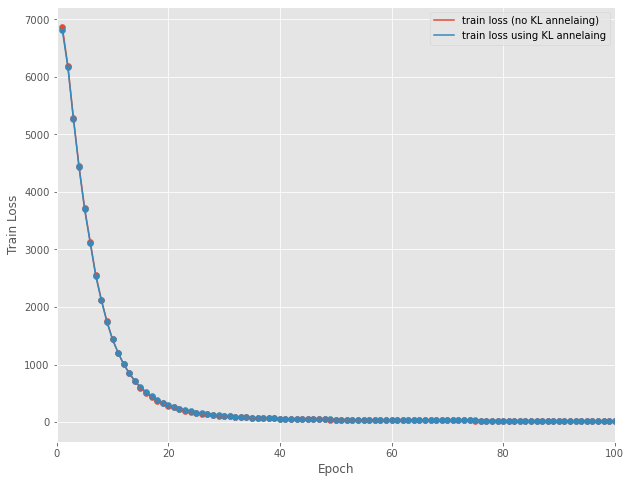

In [43]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals1)
plt.plot(epochs, train_loss_vals1, label='train loss (no KL annelaing)')
plt.scatter(epochs, train_loss_vals2)
plt.plot(epochs, train_loss_vals2, label='train loss using KL annelaing')
plt.xlim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("train_loss_comparisons_GS.pdf", format="pdf", bbox_inches="tight")
plt.show()

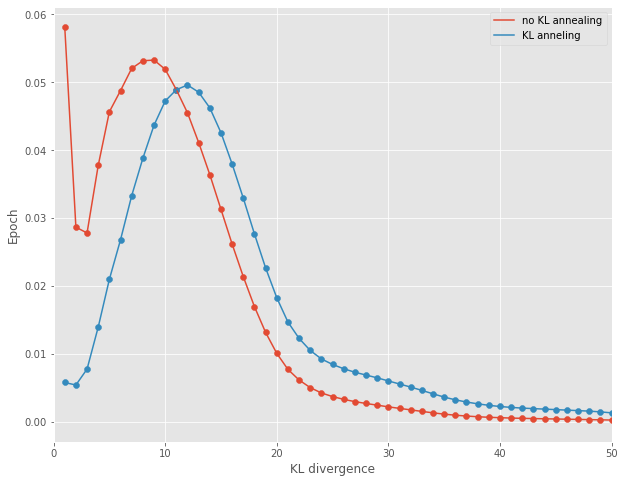

In [44]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta)
plt.plot(epochs, kl_divergences_no_beta, label='no KL annealing')
plt.scatter(epochs, kl_divergences_beta)
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling')
plt.xlim(0, 50)
plt.xlabel('KL divergence')
plt.ylabel('Epoch')
plt.legend()
plt.savefig("kl_divergence_comparison_no_GS.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [45]:
# GRADIENT CLIPPING PLUS SCHEDULER USED 
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0
free_bits = 0.1
n_epochs = 10

# Model
model = VAE_single(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Overfitting
model.train()
num_epochs = 1000 

# Gradient clipping and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

# Collecting data for visualisation 
train_loss_vals1 = []
train_loss_vals2 = []
kl_divergences_no_beta = []
kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / n_epochs
    epoch_kl_divergence = 0
    epoch_kl_divergence_beta = 0 

    for data in single_sample_loader:
        data = data[0].to(torch.float)

        # print(data)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())
        
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        epoch_kl_divergence += kl_divergence_loss.item()
        epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        loss = reconstruction_loss + kl_divergence_loss
        loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    scheduler.step()  

    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss (method1) = {loss.item()}")
        print(f"Epoch {epoch}: Loss (method2) = {loss2.item()}")

    train_loss_vals1.append(loss.item())
    train_loss_vals2.append(loss2.item())

    kl_divergences_no_beta.append(epoch_kl_divergence / len(train_loader.dataset))
    kl_divergences_beta.append(epoch_kl_divergence_beta / len(train_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss.item()}")

Epoch 0: Loss (method1) = 6847.52099609375
Epoch 0: Loss (method2) = 6806.029296875
Epoch 100: Loss (method1) = 0.9994024634361267
Epoch 100: Loss (method2) = 2.275235176086426
Epoch 200: Loss (method1) = 0.27019238471984863
Epoch 200: Loss (method2) = 2.550827980041504
Epoch 300: Loss (method1) = 0.1337774693965912
Epoch 300: Loss (method2) = 2.0996272563934326
Epoch 400: Loss (method1) = 0.08101450651884079
Epoch 400: Loss (method2) = 1.822771668434143
Epoch 500: Loss (method1) = 0.031184036284685135
Epoch 500: Loss (method2) = 0.5480912923812866
Epoch 600: Loss (method1) = 0.023063577711582184
Epoch 600: Loss (method2) = 0.555694580078125
Epoch 700: Loss (method1) = 0.012850377708673477
Epoch 700: Loss (method2) = 0.22772499918937683
Epoch 800: Loss (method1) = 0.009655834175646305
Epoch 800: Loss (method2) = 0.18481206893920898
Epoch 900: Loss (method1) = 0.010279625654220581
Epoch 900: Loss (method2) = 0.37726104259490967
Final Loss after 1000 epochs: 0.005605996120721102


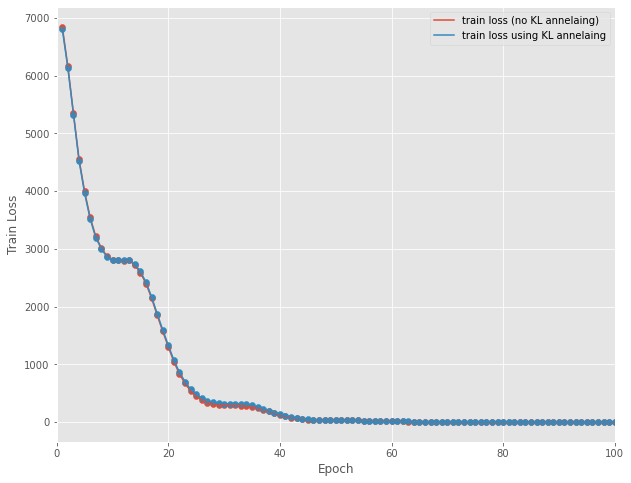

In [46]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals1)
plt.plot(epochs, train_loss_vals1, label='train loss (no KL annelaing)')
plt.scatter(epochs, train_loss_vals2)
plt.plot(epochs, train_loss_vals2, label='train loss using KL annelaing')
plt.xlim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("train_loss_comparisons_GS.pdf", format="pdf", bbox_inches="tight")
plt.show()

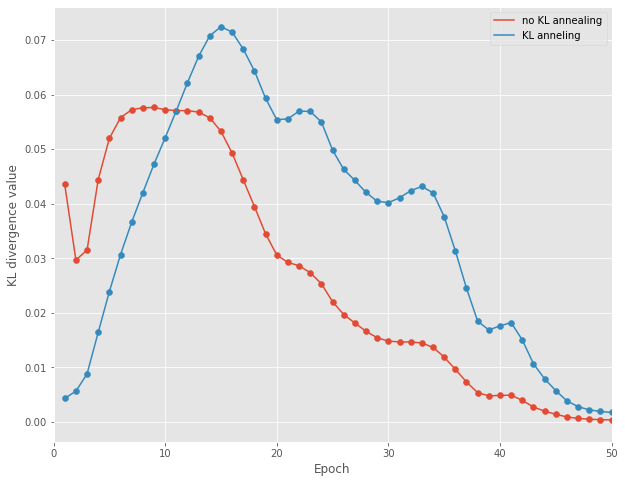

In [47]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta)
plt.plot(epochs, kl_divergences_no_beta, label='no KL annealing')
plt.scatter(epochs, kl_divergences_beta)
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling')
plt.xlim(0, 50)
plt.xlabel('Epoch')
plt.ylabel('KL divergence value')
plt.legend()
plt.savefig("kl_divergence_comparison_GS.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 3.2) Overfitting on a small train subset

In [48]:
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0
free_bits = 0.1

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
num_epochs = 1000  

train_loss_vals1 = []
# train_loss_vals2 = []
kl_divergences_no_beta = []
# kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / num_epochs
    epoch_kl_divergence = 0
    for data in small_loader:
        data = data[0].to(torch.float)
        # print(data)
    
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())

        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        epoch_kl_divergence += kl_divergence_loss.item()
        # epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        loss = reconstruction_loss + kl_divergence_loss
        # loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        loss.backward()
        optimizer.step()   

    if epoch % 100 == 0:
        print(f"Epoch {epoch}\nLoss (method1) = {loss.item()}")

    train_loss_vals1.append(loss.item())
    # train_loss_vals2.append(loss2.item())

    kl_divergences_no_beta.append(epoch_kl_divergence / len(train_loader.dataset))
    # kl_divergences_beta.append(epoch_kl_divergence_beta / len(train_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss.item()}")

Epoch 0
Loss (method1) = 104736.2890625
Epoch 100
Loss (method1) = 9220.2197265625
Epoch 200
Loss (method1) = 3769.236572265625
Epoch 300
Loss (method1) = 4530.64892578125
Epoch 400
Loss (method1) = 1989.79150390625
Epoch 500
Loss (method1) = 1824.1397705078125
Epoch 600
Loss (method1) = 1551.564453125
Epoch 700
Loss (method1) = 2148.399658203125
Epoch 800
Loss (method1) = 1962.85400390625
Epoch 900
Loss (method1) = 1701.8651123046875
Final Loss after 1000 epochs: 1627.82666015625


In [49]:
# Save trained model
torch.save(model.state_dict(), "saved_small_VAE1.pt")
print("Model saved.")

Model saved.


In [50]:
epochs = np.linspace(1, 1000, num=1000)

No handles with labels found to put in legend.


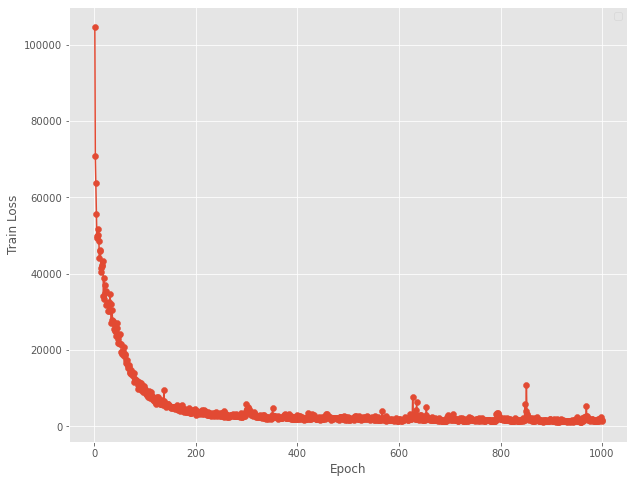

In [51]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals1)
plt.plot(epochs, train_loss_vals1)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("train_loss_small_ds1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [52]:
# plt.figure(figsize=(10,8))
# plt.scatter(epochs, kl_divergences_no_beta)
# plt.plot(epochs, kl_divergences_no_beta, label='no KL annealing')
# plt.scatter(epochs, kl_divergences_beta)
# plt.plot(epochs, kl_divergences_beta, label = 'KL anneling')
# plt.xlim(0, 50)
# plt.xlabel('Epoch')
# plt.ylabel('KL divergence value')
# plt.legend()
# plt.savefig("kl_divergence_comparison_GS.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [53]:
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0
free_bits = 0.1

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
num_epochs = 1000  

# train_loss_vals1 = []
train_loss_vals2 = []
# kl_divergences_no_beta = []
kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / num_epochs
    epoch_kl_divergence_beta = 0
    for data in small_loader:
        data = data[0].to(torch.float)
        # print(data)
    
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())

        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        # epoch_kl_divergence += kl_divergence_loss.item()
        epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        # loss = reconstruction_loss + kl_divergence_loss
        loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        loss2.backward()
        optimizer.step()   

    if epoch % 100 == 0:
        print(f"Epoch {epoch}\nLoss (method 2) = {loss2.item()}")

    # train_loss_vals1.append(loss.item())
    train_loss_vals2.append(loss2.item())

    # kl_divergences_no_beta.append(epoch_kl_divergence / len(train_loader.dataset))
    kl_divergences_beta.append(epoch_kl_divergence_beta / len(train_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss2.item()}")

Epoch 0
Loss (method 2) = 102381.859375
Epoch 100
Loss (method 2) = 4000.54736328125
Epoch 200
Loss (method 2) = 2009.6224365234375
Epoch 300
Loss (method 2) = 1487.459716796875
Epoch 400
Loss (method 2) = 1724.544677734375
Epoch 500
Loss (method 2) = 1364.623779296875
Epoch 600
Loss (method 2) = 3277.10888671875
Epoch 700
Loss (method 2) = 1367.9417724609375
Epoch 800
Loss (method 2) = 1469.1495361328125
Epoch 900
Loss (method 2) = 1769.5235595703125
Final Loss after 1000 epochs: 1733.2119140625


In [54]:
# Save trained model
torch.save(model.state_dict(), "saved_small_VAE2.pt")
print("Model saved.")

Model saved.


No handles with labels found to put in legend.


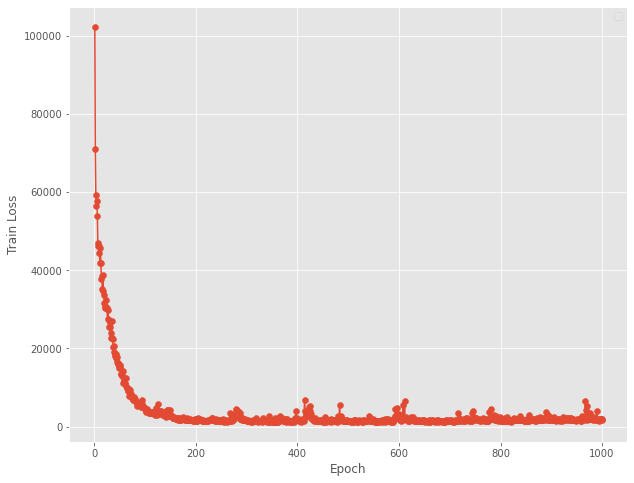

In [55]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals2)
plt.plot(epochs, train_loss_vals2)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("train_loss_small_d2.pdf", format="pdf", bbox_inches="tight")
plt.show()

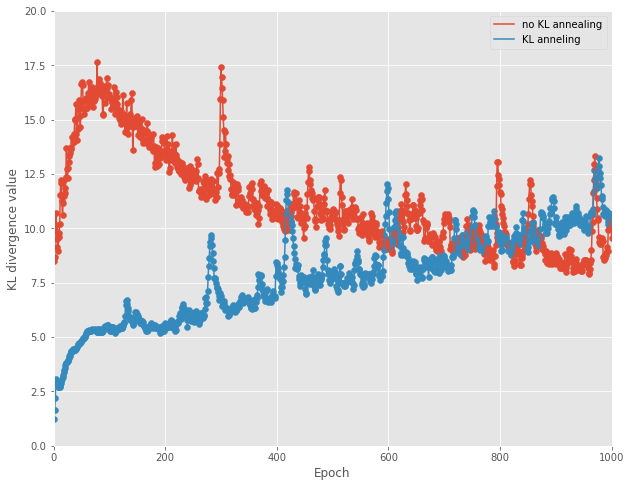

In [56]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta)
plt.plot(epochs, kl_divergences_no_beta, label = 'no KL annealing')
plt.scatter(epochs, kl_divergences_beta)
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling')
plt.xlim(0, 1000)
plt.ylim(0, 20)
plt.xlabel('Epoch')
plt.ylabel('KL divergence value')
plt.legend()
plt.savefig("kl_divergence_comparison_1_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 4) Training VAE model on full dataset (train + validation sets)

## 4.1) Training with no KL annealing 

In [57]:
def train_no_KL_annelaing(model, optimizer, scheduler, n_epochs, train_loader, val_loader, max_norm):
    global train_loss_vals 
    train_loss_vals = []
    # global train_loss_vals2 
    # train_loss_vals2 = []
    global val_loss_vals
    val_loss_vals = []
    train_loss = 0.0
    # train_loss2 = 0.0
    val_loss = 0.0
    # best_val_loss = float('inf')
    # early_stopping_patience = 5
    # early_stopping_counter = 0

    for epoch in range(n_epochs):
        model.train()

        epoch_train_loss = 0.0
        # epoch_train_loss2 = 0.0

        for batch in train_loader:
            data = batch[0].to(torch.float)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(data)
            # print('reco_x:', recon_x[:1, :5])
            # print('data:', data[:1, :5])

            # print(recon_x.shape)
            # print(data.shape) 

            reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, data, reduction='sum')
            kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_divergence_loss
            # loss2 = reconstruction_loss + (beta * kl_divergence_loss)

            loss.backward()
            
            # Need to read more on gradient clipping 
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()

            epoch_train_loss += loss.item()
            # epoch_train_loss2 += loss2.item()

            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f'{name} gradient: {param.grad.abs().mean().item()}') 

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        # avg_train_loss2 = epoch_train_loss2 / len(train_loader.dataset)
        train_loss_vals.append(avg_train_loss)
        # train_loss_vals2.append(avg_train_loss2)

        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                data = batch[0]
                recon_x, mu, logvar = model(data)
                reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, data, reduction='sum')
                kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = reconstruction_loss + kl_divergence_loss

                epoch_val_loss += loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_loss_vals.append(avg_val_loss)

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}:\n"
                  f" Learning Rate: {scheduler.get_last_lr()[0]}\n"
                  f" Train Loss (method 1): {avg_train_loss}\n"
                #   f" Train Loss (method 2): {avg_train_loss2}\n"
                  f" Validation Loss: {avg_val_loss}")

        train_loss += avg_train_loss
        # train_loss2 += avg_train_loss2
        val_loss += avg_val_loss

        # # Check for early stopping
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     early_stopping_counter = 0
        # else:
        #     early_stopping_counter += 1

        # if early_stopping_counter >= early_stopping_patience:
        #     print("Early stopping triggered")
        #     break

    final_avg_train_loss = train_loss / n_epochs
    # final_avg_train_loss2 = train_loss2 / n_epochs
    final_avg_val_loss = val_loss / n_epochs

    print(f"\nFinal Average Training Loss (method 1): {final_avg_train_loss}")
    # print(f"Final Average Training Loss (method 2): {final_avg_train_loss2}")
    print(f"Final Average Validation Loss: {final_avg_val_loss}")

In [58]:
# Create a smaller subset of the training data
small_subset_indices = np.random.choice(len(train_dataset), size=256, replace=False)
small_subset = Subset(train_dataset, small_subset_indices)
small_loader = DataLoader(small_subset, batch_size=batch_size, shuffle=True)

In [59]:
# Model
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64

model1 = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_norm = 1.0 
beta_start = 0.1
beta_end = 1.0
free_bits = 0.1
n_epochs = 100

train_no_KL_annelaing(model=model1, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, max_norm=max_norm)

Epoch 10:
 Learning Rate: 1e-05
 Train Loss (method 1): 5228.868226769063
 Validation Loss: 5252.192438089623
Epoch 20:
 Learning Rate: 5e-06
 Train Loss (method 1): 4300.866371392528
 Validation Loss: 4321.685318396227
Epoch 30:
 Learning Rate: 5e-06
 Train Loss (method 1): 3901.7416222187794
 Validation Loss: 3944.753935731132
Epoch 40:
 Learning Rate: 2.5e-06
 Train Loss (method 1): 3544.9950258941217
 Validation Loss: 3643.751444575472
Epoch 50:
 Learning Rate: 2.5e-06
 Train Loss (method 1): 3358.348533219724
 Validation Loss: 3458.1672464622643
Epoch 60:
 Learning Rate: 1.25e-06
 Train Loss (method 1): 3184.004821950248
 Validation Loss: 3257.3006117334908
Epoch 70:
 Learning Rate: 1.25e-06
 Train Loss (method 1): 3093.289725529686
 Validation Loss: 3169.208328419811
Epoch 80:
 Learning Rate: 6.25e-07
 Train Loss (method 1): 3001.9499361868507
 Validation Loss: 3051.4188974056606
Epoch 90:
 Learning Rate: 6.25e-07
 Train Loss (method 1): 2959.3485507406754
 Validation Loss: 3026.

In [60]:
# Save trained model
torch.save(model1.state_dict(), "saved_base_VAE.pt")
print("Model saved.")

Model saved.


In [61]:
epochs = np.linspace(1, 100, num=100)

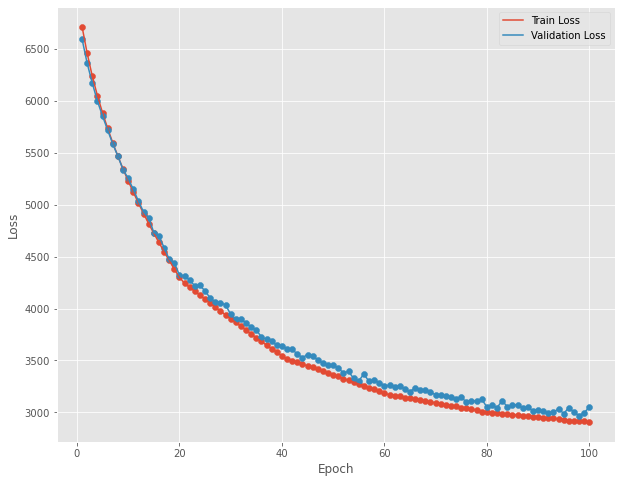

In [62]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals)
plt.plot(epochs, train_loss_vals, label='Train Loss')
plt.scatter(epochs, val_loss_vals)
plt.plot(epochs, val_loss_vals, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("first_model_train_val_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 4.2) Training using KL annealing 

In [65]:
def train_with_KL_annelaing(model, optimizer, scheduler, n_epochs, train_loader, val_loader, beta_start, beta_end, max_norm):
    # global train_loss_vals 
    # train_loss_vals = []
    global train_loss_vals2 
    train_loss_vals2 = []
    global val_loss_vals
    val_loss_vals = []
    # train_loss = 0.0
    train_loss2 = 0.0
    val_loss = 0.0
    # best_val_loss = float('inf')
    # early_stopping_patience = 5
    # early_stopping_counter = 0

    for epoch in range(n_epochs):
        beta = beta_start + (beta_end - beta_start) * epoch / n_epochs
        model.train()

        # epoch_train_loss = 0.0
        epoch_train_loss2 = 0.0

        for batch in train_loader:
            data = batch[0].to(torch.float)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(data)
            # print('reco_x:', recon_x[:1, :5])
            # print('data:', data[:1, :5])

            # print(recon_x.shape)
            # print(data.shape) 

            reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, data, reduction='sum')
            kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            # loss = reconstruction_loss + kl_divergence_loss
            loss2 = reconstruction_loss + (beta * kl_divergence_loss)

            loss2.backward()
            
            # Need to read more on gradient clipping 
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()

            # epoch_train_loss += loss.item()
            epoch_train_loss2 += loss2.item()

            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f'{name} gradient: {param.grad.abs().mean().item()}') 

        # avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_train_loss2 = epoch_train_loss2 / len(train_loader.dataset)
        # train_loss_vals.append(avg_train_loss)
        train_loss_vals2.append(avg_train_loss2)

        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                data = batch[0]
                recon_x, mu, logvar = model(data)
                reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, data, reduction='sum')
                kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss2 = reconstruction_loss + (beta * kl_divergence_loss)

                epoch_val_loss += loss2.item()

        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_loss_vals.append(avg_val_loss)

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}:\n"
                  f" Learning Rate: {scheduler.get_last_lr()[0]}\n"
                #   f" Train Loss (method 1): {avg_train_loss}\n"
                  f" Train Loss (method 2): {avg_train_loss2}\n"
                  f" Validation Loss: {avg_val_loss}")

        # train_loss += avg_train_loss
        train_loss2 += avg_train_loss2
        val_loss += avg_val_loss

        # # Check for early stopping
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     early_stopping_counter = 0
        # else:
        #     early_stopping_counter += 1

        # if early_stopping_counter >= early_stopping_patience:
        #     print("Early stopping triggered")
        #     break

    # final_avg_train_loss = train_loss / n_epochs
    final_avg_train_loss2 = train_loss2 / n_epochs
    final_avg_val_loss = val_loss / n_epochs

    # print(f"\nFinal Average Training Loss (method 1): {final_avg_train_loss}")
    print(f"Final Average Training Loss (method 2): {final_avg_train_loss2}")
    print(f"Final Average Validation Loss: {final_avg_val_loss}")

In [66]:
train_with_KL_annelaing(model=model1, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, max_norm=max_norm)

Epoch 10:
 Learning Rate: 3.125e-07
 Train Loss (method 2): 2858.2468167197826
 Validation Loss: 2942.0489460495282
Epoch 20:
 Learning Rate: 1.5625e-07
 Train Loss (method 2): 2839.3006599865735
 Validation Loss: 2931.989386792453
Epoch 30:
 Learning Rate: 1.5625e-07
 Train Loss (method 2): 2826.597721723029
 Validation Loss: 2898.415271226415
Epoch 40:
 Learning Rate: 7.8125e-08
 Train Loss (method 2): 2821.6744681008026
 Validation Loss: 2926.0755527712263
Epoch 50:
 Learning Rate: 7.8125e-08
 Train Loss (method 2): 2820.530897736662
 Validation Loss: 2905.3105910966983
Epoch 60:
 Learning Rate: 3.90625e-08
 Train Loss (method 2): 2810.9671150185904
 Validation Loss: 2893.001916273585
Epoch 70:
 Learning Rate: 3.90625e-08
 Train Loss (method 2): 2812.9391681790016
 Validation Loss: 2881.116450471698
Epoch 80:
 Learning Rate: 1.953125e-08
 Train Loss (method 2): 2809.2484710664544
 Validation Loss: 2902.38742629717
Epoch 90:
 Learning Rate: 1.953125e-08
 Train Loss (method 2): 2808.3

In [67]:
# Save trained model
torch.save(model1.state_dict(), "saved_KL_annealing_VAE.pt")
print("Model saved.")

Model saved.


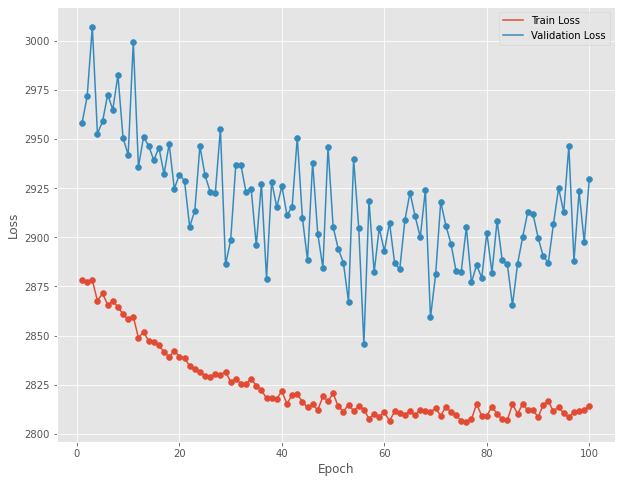

In [68]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals2)
plt.plot(epochs, train_loss_vals2, label='Train Loss')
plt.scatter(epochs, val_loss_vals)
plt.plot(epochs, val_loss_vals, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("second_model_train_val_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

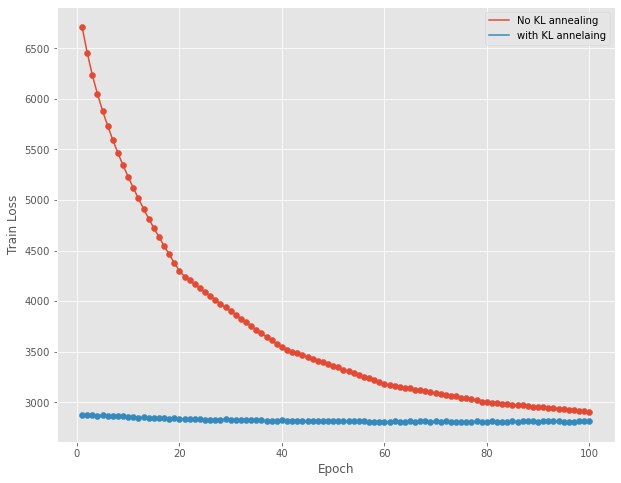

In [69]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals)
plt.plot(epochs, train_loss_vals, label='No KL annealing')
plt.scatter(epochs, train_loss_vals2)
plt.plot(epochs, train_loss_vals2, label='with KL annelaing')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("compare_first_second_train_losses.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 4.3) (Experiment) Training a MoG VAE (later)

In [70]:
# num_components = 3
# model2 = VAEWithMoGPrior(input_dim, hidden_dim, latent_dim, num_components).to(device)
# optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# train(model=model2, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, free_bits=free_bits, max_norm=max_norm)

In [71]:
# # save trained model
# torch.save(model2.state_dict(), "saved_MoG_VAE.pt")
# print("Model saved.")

# 5) Observing the latent spaces of the model(s) fitted

In [72]:
# Function to extract latent variables
def get_latent_variables(model, data_loader, device):
    model.eval()
    latents = []
    with torch.no_grad():
        for batch_idx, (data,) in enumerate(data_loader):
            data = data.to(device)
            mean, logvar = model.encode(data)
            latents.append(mean.cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    return latents

In [73]:
# Trying to get teh latent space
# Get latent variables
latents = get_latent_variables(model1, train_loader, device)

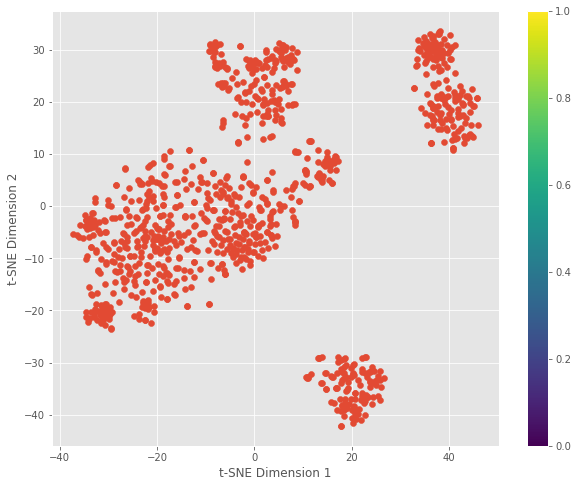

In [74]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
latents_2d = tsne.fit_transform(latents)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], cmap='viridis')
plt.colorbar(scatter)
# plt.xlim(-400, 400)
# plt.ylim(-400, 400)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig("latent_space_visualisation.pdf", format="pdf", bbox_inches="tight")
plt.show()

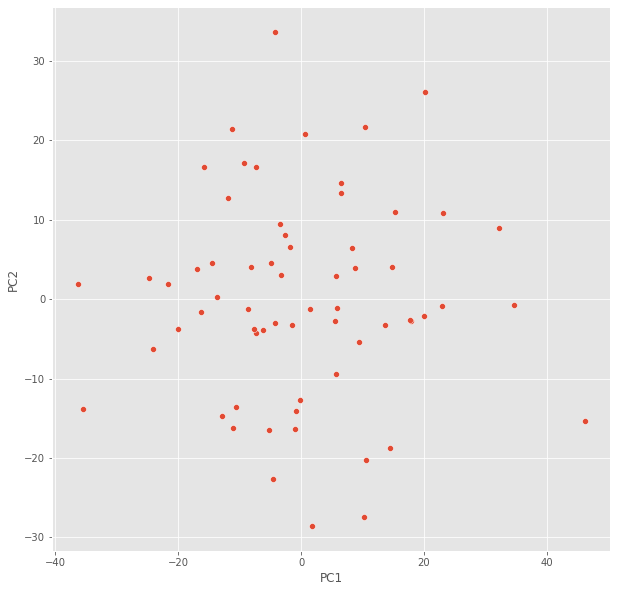

In [78]:
# Apply PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents.transpose())
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

# Visualize the first two principal components
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', data=df_pca)
plt.show()

# 5) Reconstruction/generation (evaluation) (to do later, just a test for now)

In [79]:
# Load trained model 
model = VAE(input_dim, hidden_dim, latent_dim)
model.load_state_dict(torch.load('saved_base_VAE.pt'))  
model.eval()  

# Generate 10 new samples
num_samples = 10 
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim)  # Sample from the standard normal distribution (????)
    generated_samples = model.decode(z).cpu().numpy() 

threshold = 0.5
binary_generated_samples = (generated_samples > threshold).astype(float)

print("Generated samples:\n", binary_generated_samples)
print("Generated samples:\n", generated_samples)


Generated samples:
 [[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
Generated samples:
 [[0.23789978 0.21662721 0.25959268 ... 0.8684372  0.8126377  0.8187296 ]
 [0.24162279 0.23334669 0.24844019 ... 0.80771863 0.83022165 0.84975296]
 [0.16449876 0.23575257 0.2023691  ... 0.7869754  0.8082691  0.7570574 ]
 ...
 [0.26379675 0.24255215 0.26107538 ... 0.79368126 0.8182925  0.7881355 ]
 [0.2220427  0.19127405 0.24163593 ... 0.83818245 0.82426316 0.8348567 ]
 [0.2633856  0.27968872 0.22503445 ... 0.81322867 0.77580076 0.79723465]]


# 6) Gridsearch best params

In [80]:
# # Gridsearch
# hidden_dim_values = [256, 512, 1024]
# latent_dim_values = [32, 64, 128]
# learning_rate_values = [1e-3, 1e-4, 1e-5]
# beta_start_values = [0.01, 0.1, 0.2]
# beta_end_values = [0.5, 1.0, 2.0]
# free_bits_values = [0.0, 0.1, 0.2]
# max_norm_values = [0.5, 1.0, 2.0]

# # Experiment with different hyperparameter combinations
# for hidden_dim, latent_dim, learning_rate, beta_start, beta_end, free_bits, max_norm in itertools.product(
#     hidden_dim_values, latent_dim_values, learning_rate_values, beta_start_values, beta_end_values, free_bits_values, max_norm_values):
#     print(f"Training with hidden_dim={hidden_dim}, latent_dim={latent_dim}, learning_rate={learning_rate}, beta_start={beta_start}, beta_end={beta_end}, free_bits={free_bits}, max_norm={max_norm}")
#     model = VAE(input_dim, hidden_dim, latent_dim).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     train1(model, optimizer, scheduler=0, n_epochs=10, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, free_bits=free_bits, max_norm=max_norm)